<a href="https://colab.research.google.com/github/sauravrox/image-text-detection/blob/main/Text_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import csv
import gzip
import collections
import re
import io
import json
import xml.etree.ElementTree as ET

import requests
import pandas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
xml_path = os.path.join('/content/drive/MyDrive/image/drugbank.xml.gz')
with gzip.open(xml_path) as xml_file:
    tree = ET.parse(xml_file)
root = tree.getroot()

In [ ]:
ns = '{http://www.drugbank.ca}'
inchikey_template = "{ns}calculated-properties/{ns}property[{ns}kind='InChIKey']/{ns}value"
inchi_template = "{ns}calculated-properties/{ns}property[{ns}kind='InChI']/{ns}value"

rows = list()
for i, drug in enumerate(root):
    row = collections.OrderedDict()
    assert drug.tag == ns + 'drug'
    row['type'] = drug.get('type')
    row['drugbank_id'] = drug.findtext(ns + "drugbank-id[@primary='true']")
    row['name'] = drug.findtext(ns + "name")
    row['description'] = drug.findtext(ns + "description")
    row['groups'] = [group.text for group in
        drug.findall("{ns}groups/{ns}group".format(ns = ns))]
    row['atc_codes'] = [code.get('code') for code in
        drug.findall("{ns}atc-codes/{ns}atc-code".format(ns = ns))]
    row['categories'] = [x.findtext(ns + 'category') for x in
        drug.findall("{ns}categories/{ns}category".format(ns = ns))]
    row['inchi'] = drug.findtext(inchi_template.format(ns = ns))
    row['inchikey'] = drug.findtext(inchikey_template.format(ns = ns))
    
    # Add drug aliases
    aliases = {
        elem.text for elem in 
        drug.findall("{ns}international-brands/{ns}international-brand".format(ns = ns)) +
        drug.findall("{ns}synonyms/{ns}synonym[@language='English']".format(ns = ns)) +
        drug.findall("{ns}international-brands/{ns}international-brand".format(ns = ns)) +
        drug.findall("{ns}products/{ns}product/{ns}name".format(ns = ns))

    }
    aliases.add(row['name'])
    row['aliases'] = sorted(aliases)

    rows.append(row)

In [ ]:
alias_dict = {row['drugbank_id']: row['aliases'] for row in rows}
with open('/content/drive/MyDrive/image/aliases.json', 'w') as fp:
    json.dump(alias_dict, fp, indent=2, sort_keys=True)

In [ ]:
def collapse_list_values(row):
    for key, value in row.items():
        if isinstance(value, list):
            row[key] = '|'.join(value)
    return row

rows = list(map(collapse_list_values, rows))
columns = ['drugbank_id', 'name', 'type', 'groups', 'atc_codes', 'categories', 'inchikey', 'inchi', 'description']
drugbank_df = pandas.DataFrame.from_dict(rows)[columns]
drugbank_df.head()

,drugbank_id,name,type,groups,atc_codes,categories,inchikey,inchi,description
0,DB00001,Lepirudin,biotech,approved,B01AE02,Antithrombins|Fibrinolytic Agents,None,None,Lepirudin is identical to natural hirudin exce...
1,DB00002,Cetuximab,biotech,approved,L01XC06,Antineoplastic Agents,None,None,Epidermal growth factor receptor binding FAB. ...
2,DB00003,Dornase alfa,biotech,approved,R05CB13,Enzymes,None,None,Dornase alfa is a biosynthetic form of human d...
3,DB00004,Denileukin diftitox,biotech,approved|investigational,L01XX29,Antineoplastic Agents,None,None,A recombinant DNA-derived cytotoxic protein co...
4,DB00005,Etanercept,biotech,approved|investigational,L04AB01,Immunosuppressive Agents,None,None,Dimeric fusion protein consisting of the extra...


In [ ]:
!pip install tesseract-ocr
!pip install libtesseract-dev
!pip install pytesseract

  ERROR: Failed building wheel for tesseract-ocr
  Running setup.py clean for tesseract-ocr
Failed to build tesseract-ocr
    Running setup.py install for tesseract-ocr ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-2yhtjcrt/tesseract-ocr_39fb8737b8f64412bb606794debc3a67/setup.py'"'"'; __file__='"'"'/tmp/pip-install-2yhtjcrt/tesseract-ocr_39fb8737b8f64412bb606794debc3a67/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-qcvzbjmm/install-record.txt --single-version-externally-managed --compile --install-headers /usr/local/include/python3.7/tesseract-ocr Check the logs for full command output.
ERROR: Could not find a version t

In [ ]:
import pandas as pd
import numpy as np
import cv2
import pytesseract
custom_config = r' — oem 3 — psm 6'
from matplotlib import pyplot as plt

In [ ]:
# !sudo apt install tesseract-ocr

In [ ]:
from PIL import ImageFont, ImageDraw, Image

filepath = '/content/drive/MyDrive/image/download.jpeg'
img = Image.open(filepath)
  
# get width and height
width = img.width
height = img.height

def find_font_size(text, font, image, target_width_ratio):
    tested_font_size = 100
    tested_font = ImageFont.truetype(font, tested_font_size)
    observed_width, observed_height = get_text_size(text, image, tested_font)
    if(observed_width>0):
      estimated_font_size = tested_font_size / (observed_width / width) * target_width_ratio
      return round(estimated_font_size)

def get_text_size(text, image, font):
    im = Image.new('RGB', (width, height))
    draw = ImageDraw.Draw(im)
    return draw.textsize(text, font)

width_ratio = 0.5
font_family = os.path.join("/content/drive/MyDrive/image/arial.ttf")

In [ ]:
import re
import cv2 
import numpy as np
import pytesseract
from pytesseract import Output
from matplotlib import pyplot as plt

In [ ]:
# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

def image_smoothening(img):
    kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
    image_sharp = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)
    return image_sharp

def remove_noise_and_smooth(img):
    # img = cv2.imread(file_name, 0)
    filtered = cv2.adaptiveThreshold(img.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 41)
    kernel = np.ones((1, 1), np.uint8)
    opening = cv2.morphologyEx(filtered, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    img = image_smoothening(img)
    or_image = cv2.bitwise_or(img, closing)
    return or_image

sometimes you
READ
a book so ppecial
that you (| want to _o.
CARRY: AROUND
with you for VW you've
vont iia
finished just “G CAs
- Markus Zusak



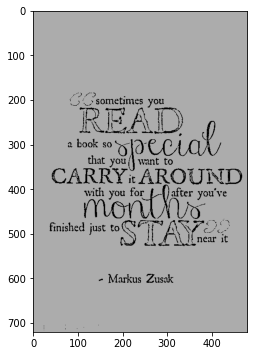

In [ ]:
from PIL import ImageFilter, ImageEnhance
from PIL import ImageChops, Image

from scipy import misc, ndimage

img = cv2.imread('/content/drive/MyDrive/image/download.jpeg',0)

fig = plt.figure(figsize=(13,13))
ax = []

rows = 2
columns = 2
# keys = list(images.keys())

ax.append( fig.add_subplot(rows, columns, 1) )
img = remove_noise_and_smooth(img)

img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

dst = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)

def adjust_gamma(image, gamma=1.0):

   invGamma = 1.0 / gamma
   table = np.array([((i / 255.0) ** invGamma) * 255
      for i in np.arange(0, 256)]).astype("uint8")

   return cv2.LUT(image, table)

gamma = 0.01
dst = adjust_gamma(dst, gamma=gamma)

# Get OCR output using Pytesseract
custom_config = r'--oem 3 --psm 6'
str1 = pytesseract.image_to_string(dst, lang="eng", config="--psm 6")

file1 = open('myfile.txt', 'w')
file1.writelines(str1)
file1.close()
 
# Using readlines()
file1 = open('myfile.txt', 'r')
Lines = file1.readlines()

for line in Lines:
  if line:
    line = line.strip()
    print(line)
    # print(find_font_size(line, font_family, dst, width_ratio))

plt.imshow(dst)